<a href="https://colab.research.google.com/github/raeubaen/giagu/blob/master/NB_LogisticRegression_LC1_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Regressione Logistica e Ricerca di Particelle Supersimmetriche #


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Informazioni

scopo: imparare a risolvere un problema di classificazioen tramite un classificatore lineare di regressione logistica, prendere dimestichezza con la libreria scikit-learn e imparare l'uso del package Pandas per la gestione di dataset complessi

campione di esempi: [SUSY dataset](https://archive.ics.uci.edu/ml/datasets/SUSY) da [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

Ci focalizzermeo in una task di classificazione binaria (segnale (SUSY) - fondo (processi del Modello Standard con stessi stati finali di quelli prodotti nei decadimenti delle particelle supersimmetriche)).


**Regressione logistica**

È una dei modelli classici del ML per la classificazione che permette di introdurre la maggior parte delle idee e techniche del ML supervisionato. 

Ogni set di fatures $\mathbf{x}_i$ è associato ad una label di categoria (classe)$C_i\in\{1,0\}$, con $i=1\ldots n$.
Di seguito il feature vector $\mathbf{x}_i$ è ridefinito via the augmented rapresentation $\mathbf{x}\rightarrow (1,\mathbf{x})$. 
La likelihood function della regressione logistica è data dalla funzione sigmoide:

$$
P(c_i=1)=1-P(c_i=0)= {1 \over 1+ e^{-\mathbf{w}\cdot \mathbf{x}_i}},
$$

in cui $\mathbf{w}$ sono i pesi che definiscono il modello di regressione logistica e che vengono scelti massimizzando la log-likelihood sul campione di dati di training. 

Definendo la funzione:
$$
f(a)={1 \over 1+ e^{-a}},
$$

con derivata rispetto a $a$:
$$
{df \over da}= f(1-f).
$$

e definendo $f_i \equiv f(\mathbf{w}\cdot \mathbf{x}_i)$, possiamo esprimere la likelihood dei dati $\{ \mathbf{x}_i, C_i \}$ come:

$$
P(Data|\mathbf{x})= \prod_{i=1}^n f_i^{C_i}(1-f_i)^{1-C_i}
$$

con log-likelihood:
$$
\log{P(Data|\mathbf{w})}= \sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i)
$$

La log-likelihood cambiata di segno fornisce la loss function ed è chiamata cross-entropy error function:
$$
\mathrm{Cross\,Entropy}=E(\mathbf{w})= -\sum_{i=1}^n C_i \log f_i + (1-C_i)\log(1-f_i).
$$

Osserviamo che:
$$
\nabla E(\mathbf{w})=\sum_{i=1}^n (f_i-C_i)\mathbf{x}_i.
$$

cioè il gradiente punta nella direzione della somma delle direzioni dei vettori del training set pesata con la differenza tra la label vera e la probabilità di predire la label stessa.

La stima di massima verosimiglianza (MLE) corrisponde alla minimizzazione della cross-entropia. Questo può essere fatto usando metodi di discesa lungo il gradiente.

### Passo 1: carica il dataset con pandas

**informazioni sul dataset:**

>Provide all relevant informatioThe data has been produced using Monte Carlo simulations. The first 8 features are kinematic properties measured by the particle detectors in the accelerator. The last ten features are functions of the first 8 features; these are high-level features derived by physicists to help discriminate between the two classes.

* data format: The first column is the class label (1 for signal, 0 for background), followed by the 18 features (8 low-level features then 10 high-level features):: lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1). For detailed information about each feature see the original paper.


* reference: <cite> P. Baldi, P. Sadowski, and D. Whiteson. "Searching for Exotic Particles in High-energy Physics with Deep Learning." Nature Communications 5 (July 2, 2014)</cite>.

Il campione che potete scaricare da qui [Campione SUSY.csv 1M eventi](https://www.dropbox.com/s/qfvjlrdz38goien/SUSY.csv?dl=0) contiene solo 1M degli 11M di eventi del dataset totale (per mantenere la size limitata).

Importiamo il dataset cono pandas usando i primi 950k eventi come training set e i secondi 50k come test set.

In [0]:
# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings

#warnings.filterwarnings('ignore') #se non si vogliono ricevere warning scommentare questa riga


seed=12345
np.random.seed(seed)

# Download SUSY.csv 
filename="/content/drive/My Drive/Colab Notebooks/dataset/SUSY.csv"
#filename=sample_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 950k rows as train data, 50k as test data
df_train=pd.read_csv(filename,names=columns,nrows=950000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=950000,engine='python')

**Definizione funzioni utili in pandas:**

In [0]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

#accede in pandas ai dati del campione di training e li formatta in modo comodo
def getTrainData(nVar):
    designMatrix = df_train.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_train['signal'].values # labels (0 or 1)
    return (designMatrix,labels)

#accede in pandas ai dati del campione di test e li formatta in modo comodo 
def getTestData(nVar):
    designMatrix = df_test.iloc[:,1:nVar+1].values
    #now the signal
    labels = df_test['signal'].values
    return (designMatrix,labels)

# usa pandas per costruire curve pseudo-ROC
def build_roc_curve(probs, signal_bit, threshes):
    # Convert things to a pandas series to build a DataFrame
    # which will make ROC curve logic easier to express
    signal_probs = pd.Series(probs[:,1])
    signal_true = pd.Series(signal_bit)
    signal_df = pd.DataFrame(signal_probs, columns=['sig_prob'])
    signal_df.loc[:,'sig_true'] = signal_true
    Acceptance = []
    Rejection = []
    for thresh in threshes:
        # define acceptance
        signal_df.loc[:,'accept'] = signal_df['sig_prob'] > thresh
        # sum over data frame with slicing conditions
        nSigCor = len(signal_df[(signal_df['accept']) & (signal_df['sig_true']==1.)])
        nSig = len(signal_df[signal_df['sig_true']==1.])
        nBkgCor = len(signal_df[ (signal_df['sig_true']==0.) & (~signal_df['accept'])])
        nBkg = len(signal_df[signal_df['sig_true']==0.])
        Acceptance.append(nSigCor/nSig) # False positive rate
        Rejection.append(nBkgCor/nBkg) # True positive rate

    return Acceptance, Rejection

### Passo 2:  Training  del modello lineare tipo logistic regression con scikit-learn

**definizione dei modelli:**

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

#logistic discriminant con regolarizzazione L2
def runSciKitRegressionL2(nVar, alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l2",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs, Acceptance, Rejection)

#logistic discriminant con regolarizzazione L1
def runSciKitRegressionL1(nVar,alpha):
    X_train, y_train = getTrainData(nVar)
    X_test, y_test = getTestData(nVar)
    clf = SGDClassifier(loss="log", penalty="l1",alpha=alpha,max_iter=5,tol=None)
    clf.fit(X_train,y_train.ravel())
    predictions = clf.predict(X_test)
    print('Accuracy on test data with alpha %.2E : %.3f' %(alpha,clf.score(X_test,y_test)) )
    probs = clf.predict_proba(X_test)

    #get signal acceptance and background rejection
    thresholds = np.arange(0,1,.01)
    Acceptance, Rejection = build_roc_curve(probs, y_test, thresholds)
    return (probs,Acceptance,Rejection)

**Training e valutazione del modello con regolarizzazione L1**

* usiamo inizialmente solo le prime 8 feature (low-level)
* $\alpha$ parametro che definisce il peso del termine di regolarizzazione e che va scelto in modo da missimizzare le prestazioni


Accuracy on test data with alpha 1.00E-10 : 0.699
Accuracy on test data with alpha 1.26E-09 : 0.692
Accuracy on test data with alpha 1.58E-08 : 0.713
Accuracy on test data with alpha 2.00E-07 : 0.756
Accuracy on test data with alpha 2.51E-06 : 0.722
Accuracy on test data with alpha 3.16E-05 : 0.768
Accuracy on test data with alpha 3.98E-04 : 0.769
Accuracy on test data with alpha 5.01E-03 : 0.768
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.542


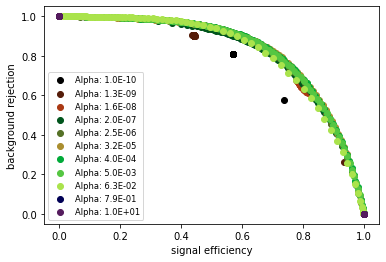

In [0]:
plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(8,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

**Osservazioni:**

abbiamo ottenuto un accuracy del 77% che è già piuttosto buona per un'analisi di questo tipo. Tramite la curva pseudo-ROC il fisico delle particelle può decidere il punto ottimale di lavoro per la data analisi (i.e. la condizione efficienza segnale vs reieizione fondo che ottimizza per esempio la sensibilità di scoperta).

Notiamo anche che i risultati sono sensibili al peso della regolarizzazione $\alpha$. In particolare i risultati delle punti della curva a peggiori prestazioni (verde scuro) indicano che in questi casi il modello non è in grado di distinguere tra le due classi. 

Ci aspettiamo che questo succeda per valori di $\alpha$ più grandi, perchè la regolarizzazione L1 effttivamente tende a "spegnere" la maggior parte delle osservabili (costringe i pesi ad essere vicini a zero), di conseguenza la classificazione risulta in effetti nel tracciare una superficie nella distribuzione di pochissime (probabilmente una sola) fetaure in input, classificando gli eventi di segnale quelli da una pate della superficie e di fondo quelli dall'altra.

Per verificarlo plottiamo la probabilità di segnale e fondo ricostruite dal modello per il caso di $\alpha$ ottimale ($\alpha = 3.98E-04$) e per il caso peggiore ($\alpha = 0.79$):

Accuracy on test data with alpha 3.98E-04 : 0.769


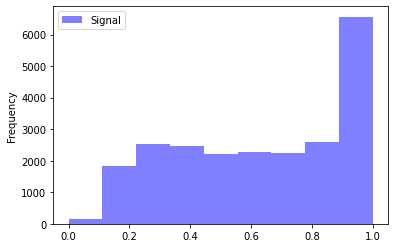

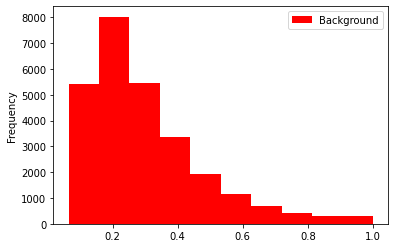

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

Accuracy on test data with alpha 7.90E-01 : 0.542


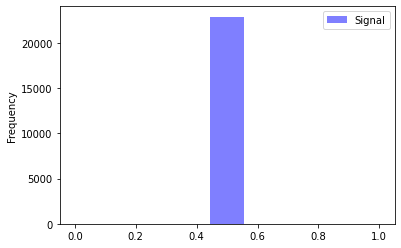

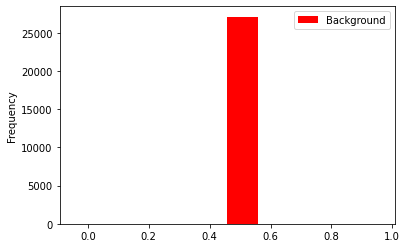

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(8,0.79)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

### Ottimizziamo ora usando tutte e 18 le osservabili ... ###

Accuracy on test data with alpha 1.00E-10 : 0.632
Accuracy on test data with alpha 1.26E-09 : 0.617
Accuracy on test data with alpha 1.58E-08 : 0.675
Accuracy on test data with alpha 2.00E-07 : 0.751
Accuracy on test data with alpha 2.51E-06 : 0.754
Accuracy on test data with alpha 3.16E-05 : 0.789
Accuracy on test data with alpha 3.98E-04 : 0.789
Accuracy on test data with alpha 5.01E-03 : 0.785
Accuracy on test data with alpha 6.31E-02 : 0.749
Accuracy on test data with alpha 7.94E-01 : 0.542
Accuracy on test data with alpha 1.00E+01 : 0.458


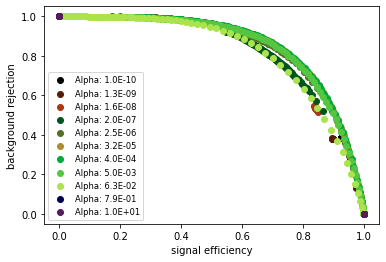

In [0]:
plt.close()
alphas = np.logspace(-10,1,11)
fig = plt.figure()
ax = fig.add_subplot(111)
it=0
for alpha in alphas:
    c1 = 1.*( float(it) % 3.)/3.0
    c2 = 1.*( float(it) % 9.)/9.0
    c3 = 1.*( float(it) % 27.)/27.0
    probs,accept,rej = runSciKitRegressionL1(18,alpha)
    ax.scatter(accept,rej,c=[[c1,c2,c3]],label='Alpha: %.1E' %alpha)
    it+=1

ax.set_xlabel('signal efficiency')
ax.set_ylabel('background rejection')
plt.legend(loc='lower left', fontsize = 'small');
plt.show()

Accuracy on test data with alpha 3.98E-04 : 0.787


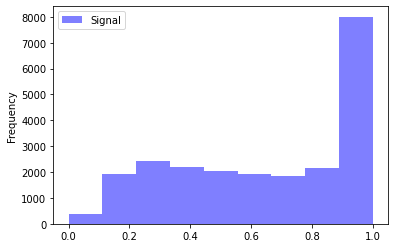

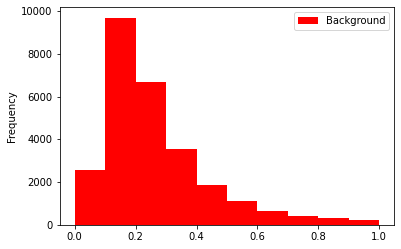

In [0]:
# grafico delle probabilità delle due classi:
probsSimple,accep,rej = runSciKitRegressionL1(18,3.98e-4)
Signal = df_test.iloc[:,0:1]

df_test_acc = pd.DataFrame({'PROB':probsSimple[:,1]})
df_test_acc['SIG']=Signal
df_test_acc_sig = df_test_acc.query('SIG==1')
df_test_acc_bkg = df_test_acc.query('SIG==0')
df_test_acc_sig.plot(kind='hist',y='PROB',color='blue',alpha=0.5,bins=np.linspace(0,1,10),label='Signal')
df_test_acc_bkg.plot(kind='hist',y='PROB',color='red',label='Background')

abbiamo migliorato l'accuracy che ora è del 79% e, come atteso dall'usare più features, è diminuita la dipedenza dalla regolarizzazione...

<b> Esercizi:</b>

* provare ad usare la regolarizzazione L2, i risultati migliorano?

* provare a addestrare il modello dopo aver normalizzato i dati in input in modo che abbiano simile dinamica, i risultati cambiano? 

* provare ad usare dei tagli rettangolari sulle osservabili migliori, calcolate le prestaizoni in termini di efficienza e reiezione e confrontate con la ROC curva ottenuta con la regressione logistica ... 

* provate a pensare se sia possibile selezionare una regione del campione dei dati di training che permetta di migliorare le prestazioni (suggerimento: pensare a dove il guadagano dall'uso del ML ha più valore rispetto ad una analisi tradizionale cut-based).